This notebook shows the development of functions used to visualize the circulation during upwelling events.

In [1]:
import numpy as np
import numpy.ma as ma
import netCDF4 as nc
import scipy.io as sio
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
from matplotlib.dates import DateFormatter
%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/mackenzie_canyon/tools/')
import functions_plot
import functions_profiles

from salishsea_tools import nc_tools, viz_tools
from salishsea_tools import gsw_calls

In [2]:
bathy_file = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/NEMO_files/idealized/ideal_bathy_05.nc')
bathy = bathy_file['Bathymetry']

coord_lats = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/coordinates/NEMO_files/coords_02.nc')['nav_lat'][:]

path = '/ocean/imachuca/Canyons/results_mackenzie/idealized/upwelling_events/'; cfg = 'eventB_1'
grid, lon, lat, tem, sal, ssh, U, V, W, tmask = functions_plot.load_model_output(path, cfg)
utau, vtau = functions_plot.load_model_other(path, cfg)
depth_levels = grid['deptht'][:]

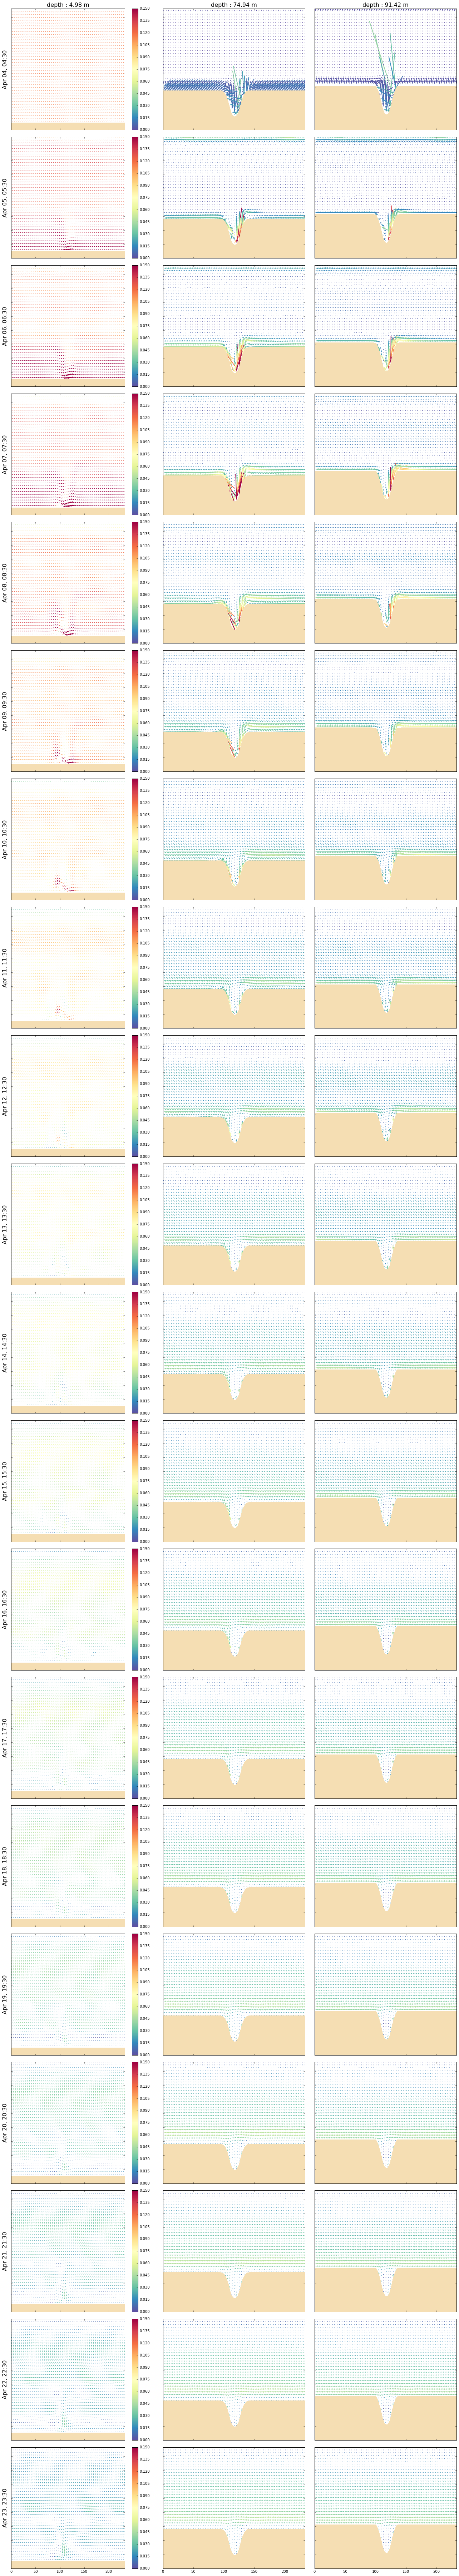

In [3]:
depth_inds = [0, 6, 7]
time_inds = np.linspace(4, 479, 20)
fig = functions_profiles.plot_quiver_stories(U, V, grid, depth_inds, time_inds, 0.15, 4, bathy_file)

In [3]:
def plot_incoming_speeds(U_vel, V_vel, gridT, depth_ind, time_inds, time_shot, max_vel, bathy_file, utau):
    
    # definitions
    x_point = 160; y_min = 55; y_max = 80
    dep_m = round(gridT['deptht'][:][depth_ind],2)
    #matplotlib.rcParams.update({'font.size': 15})

    fig = plt.figure(figsize=(20,12))
    ax1 = fig.add_subplot(2,2,1)
    ax2 = fig.add_subplot(2,2,2)
    ax3 = fig.add_subplot(2,1,2)
    fig.tight_layout()
    
    # find the speed at a depth and time to create pcolor
    x_slice, y_slice, u_nstg, v_nstg, speeds = functions_profiles.get_speeds(U_vel, V_vel, depth_ind, time_shot, 1)
    p = ax1.pcolor(speeds, vmin=0, vmax=max_vel, cmap='Spectral_r')
    viz_tools.plot_land_mask(ax1, bathy_file,'grid', dep_m, None, None, 'wheat')
    timestamp = nc_tools.timestamp(gridT, time_shot).format('MMM DD, HH:mm')
    ax1.set_title('Domain flow speeds on ' + timestamp + ' (' + str(dep_m) + ' m)')
    fig.colorbar(p, ax=ax1); ax1.set_ylabel('y index'); ax1.set_xlabel('x index')
    
    # define and plot the transect
    y_line = np.arange(y_min,y_max)
    x_line = np.ones_like(y_line)*x_point
    ax1.plot(x_line, y_line, linewidth=5, c='k', label='transect'); ax1.legend(loc=1)
    
    # plot the wind stress
    ax2.plot(np.arange(len(utau)), utau[:,-1,-1], c='k', lw=3)
    ax2.axvline(time_shot, c = 'dodgerblue', lw=3, label=timestamp)
    ax2.legend(loc=1);ax2.invert_yaxis()
    ax2.set_title('Wind stress profile'); ax2.set_xlabel('time steps'); ax2.set_ylabel('wind stress [Nm$^{-2}$]')

    # crop the velocities for the transect
    U_vel = U_vel[:, :, y_min:y_max, x_point-1:x_point+1]
    V_vel = V_vel[:, :, y_min:y_max, x_point-1:x_point+1]
    
    # get the speeds along the transect at every time index and then store in a matrix
    len_y = len(y_line)-1
    speeds_all = np.zeros([len_y,len(time_inds)])
    for time_ind, m in zip(time_inds, np.arange(len(time_inds))):
        x_slice, y_slice, u_nstg, v_nstg, speeds = functions_profiles.get_speeds(U_vel, V_vel, depth_ind, time_ind, 1)
        for n in zip(np.arange(len_y)):
            speeds_all[n, m] = speeds[n, :]
    
    # define colors for every point along the transect
    cms = np.linspace(0, 1, len_y)
    cs = [ cm.jet(x) for x in cms]
    
    # convert all time indices into datetimes and convert these into matplotlib version
    dates = []
    for i in np.arange(len(time_inds)):
        dates.append(nc_tools.get_datetimes(grid)[time_inds[i]])
    dates = matplotlib.dates.date2num(dates)
    
    # plot speeds at every point and use plot_date to use matplotlib's datetime 
    for n in np.arange(len_y):
        ax3.plot_date(dates, speeds_all[n, :], color = cs[n], linestyle='-', label = str(y_line[n]))
        
    ax3.xaxis.set_major_formatter(DateFormatter('%m-%d %H:%M'))
    ax3.legend(ncol=12, loc=1)
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Speed [m/s]')
    ax3.set_title('Speed of the incoming flow different points along the transect')
    fig.subplots_adjust(hspace=.3)
    plt.show()
    

    return fig

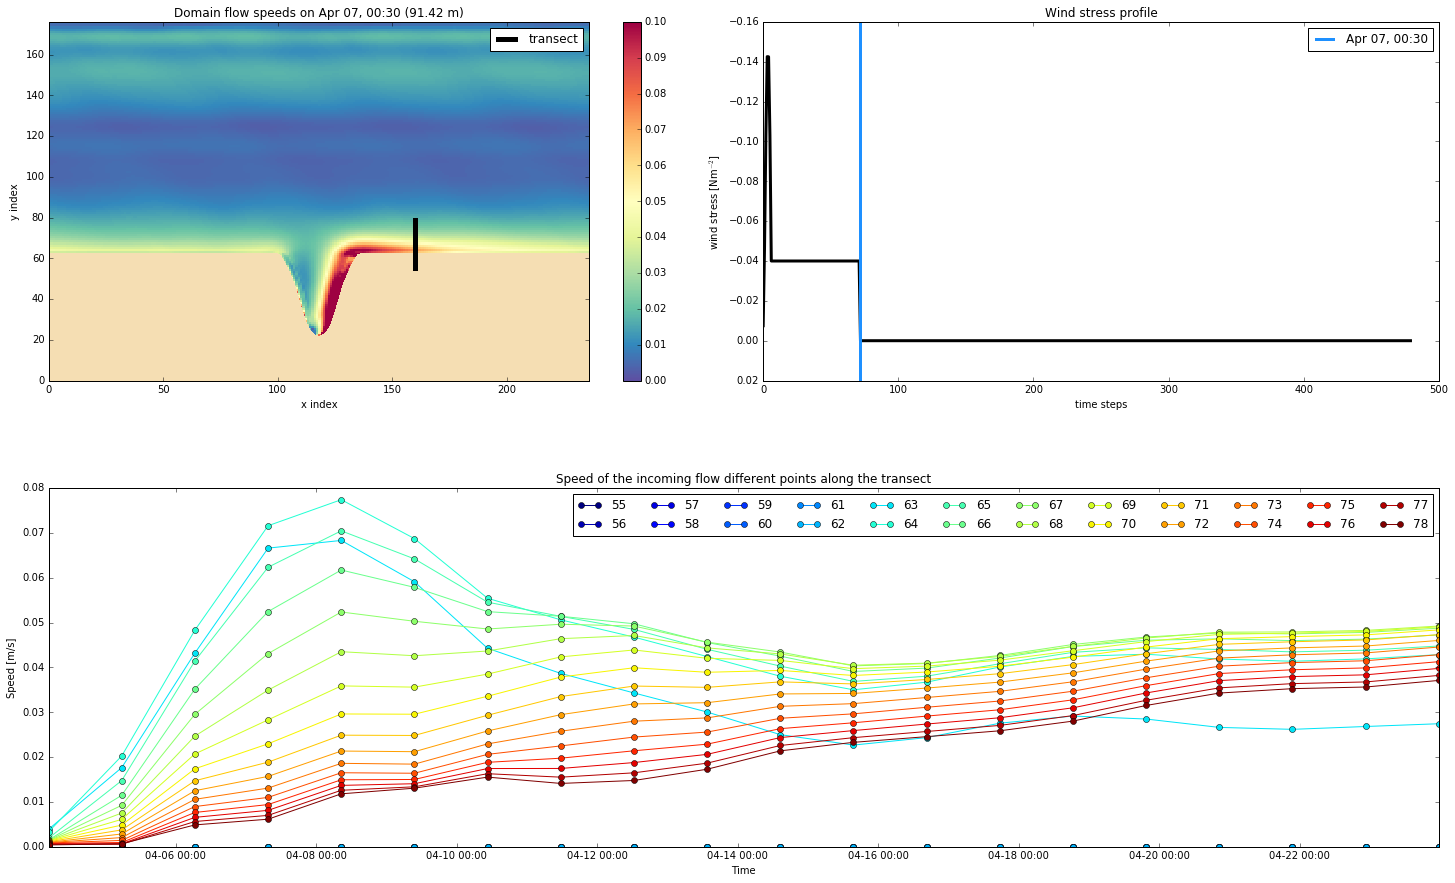

In [4]:
time_shot = 25920; nn_write_hr = 1; rn_rdt = 10; nn_write = nn_write_hr*60*60/rn_rdt
time_shot = time_shot / nn_write
time_inds = np.linspace(4, 479, 20)
fig = plot_incoming_speeds(U, V, grid, 7, time_inds, time_shot, 0.1, bathy_file, utau)

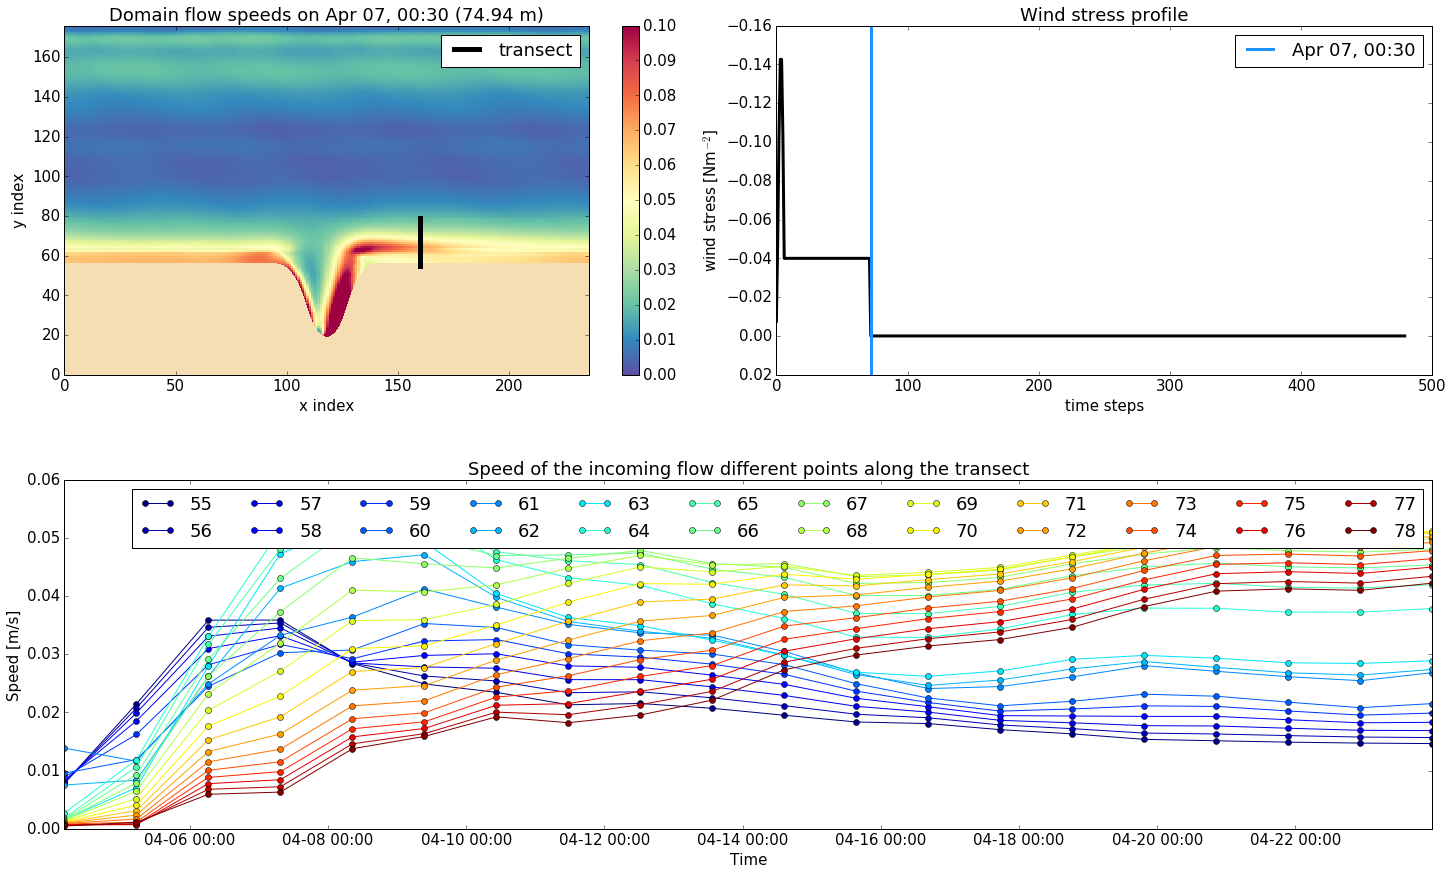

In [5]:
time_shot = 25920; nn_write_hr = 1; rn_rdt = 10; nn_write = nn_write_hr*60*60/rn_rdt
time_shot = time_shot / nn_write
time_inds = np.linspace(4, 479, 20)
fig = plot_incoming_speeds(U, V, grid, 6, time_inds, time_shot, 0.1, bathy_file, utau)

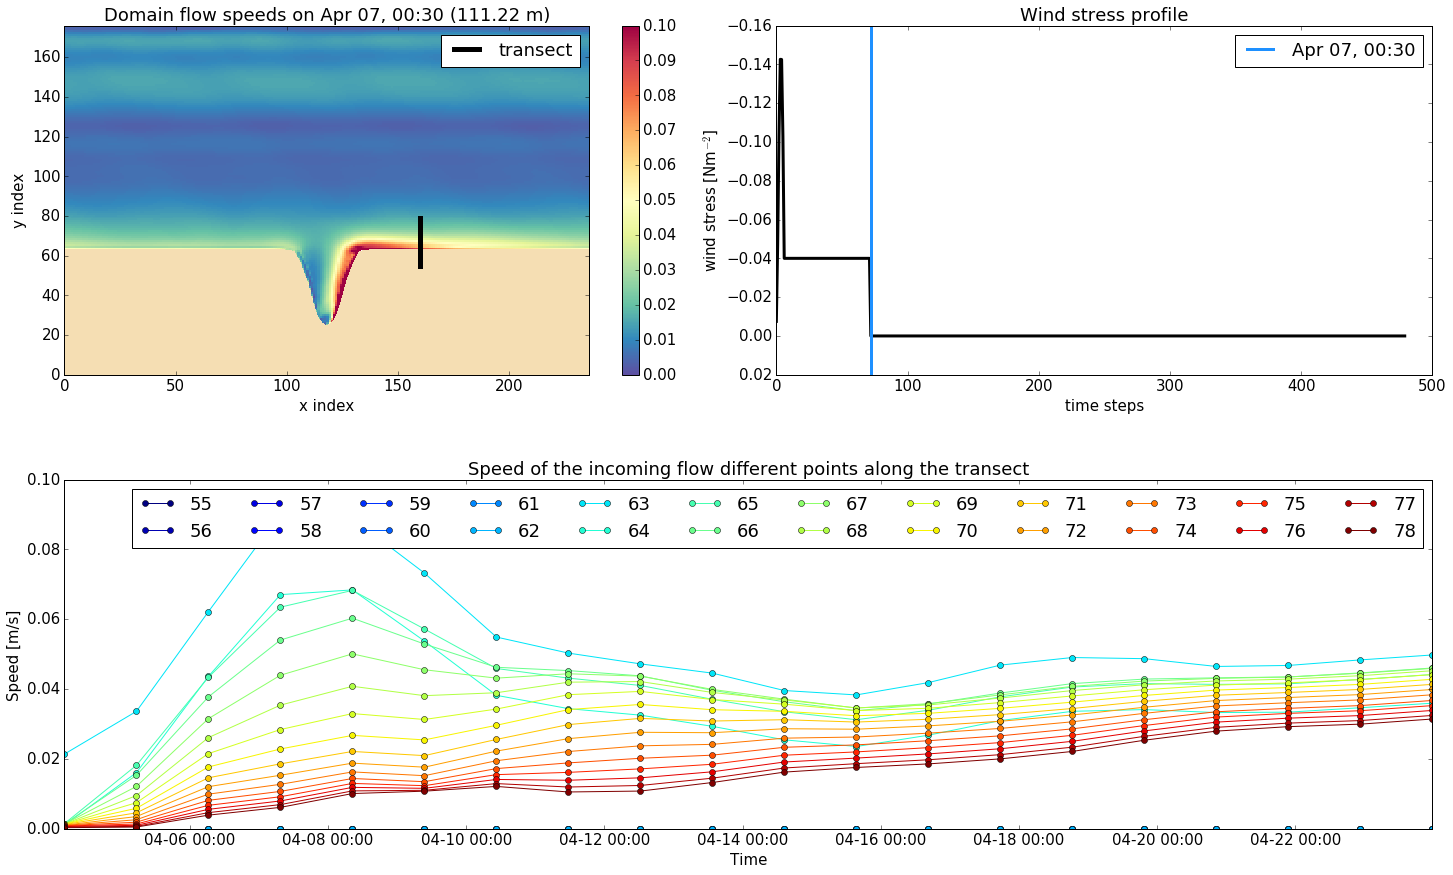

In [6]:
time_shot = 25920; nn_write_hr = 1; rn_rdt = 10; nn_write = nn_write_hr*60*60/rn_rdt
time_shot = time_shot / nn_write
time_inds = np.linspace(4, 479, 20)
fig = plot_incoming_speeds(U, V, grid, 8, time_inds, time_shot, 0.1, bathy_file, utau)

In [5]:
ts_data_deep = sio.loadmat('../data/for_stratification/canyonTSdata2.mat')
i_can, i_ref = 0, 4
sal_can = ts_data_deep['salcanyon2'][:, i_can]
sal_ref = ts_data_deep['salcanyon2'][:, i_ref]
dep_can = ts_data_deep['depthcanyon2'][:, i_can]*-1
dep_ref = ts_data_deep['depthcanyon2'][:, i_ref]*-1

In [ ]:
#ax1
time_ind = 100
inds_max_depth = np.zeros([sal.shape[2],sal.shape[3]])
for j in range(sal.shape[2]):
    for i in range(sal.shape[3]):
        sal_column = sal[time_ind, :, j, i]
        try:
            ind = np.where(sal_column == np.nanmax(sal_column))[0][0]
        except IndexError:
            ind = 0
        inds_max_depth[j, i] = ind

# ax2    
depth_ind_rim = 7
x_ind_rim_depth = np.where(inds_max_depth == depth_ind_rim)[1]
y_ind_rim_depth = np.where(inds_max_depth == depth_ind_rim)[0]

unique_x_values = np.unique(x_ind_rim_depth)
ys_for_unique_x_values = np.zeros_like(unique_x_values)
for n in range(len(ys_for_unique_x_values)):
    same_x_value = unique_x_values[n]
    inds_same_x_value = [i for i, x in enumerate(x_ind_rim_depth) if x == same_x_value]
    ys_for_same_x_value = (y_ind_rim_depth[inds_same_x_value])
    max_y_value = ys_for_same_x_value.min()
    ys_for_unique_x_values[n] = max_y_value

# ax3
sal_profiles_rim = ma.masked_all([30, len(unique_x_values)])
for y, x, n in zip(ys_for_unique_x_values, unique_x_values, np.arange(len(unique_x_values))):
    this_profile = sal[time_ind, :, y, x]
    sal_profiles_rim[:, n] = this_profile

In [19]:
# ax4 - ax9
def calculate_depth_change(ind_dep_above_rim):
    depth_change = np.zeros(sal_profiles_rim.shape[1])
    for unique_point in range(len(depth_change)):
        sal_result = sal_profiles_rim[ind_dep_above_rim, unique_point]
        ind_result_nearest_ref = min(range(len(sal_ref)), key=lambda i: abs(sal_ref[i]-sal_result))
        d_ref = dep_ref[ind_result_nearest_ref]
        d_new = grid['deptht'][ind_dep_above_rim]
        depth_change[unique_point] = d_ref - d_new
    return depth_change, d_new

def plot_rim_part(fig, axA, axB, depth_change, d_new):
    vmax, vmin = 50, -50
    axA.plot(depth_change, c = 'gray', lw=2)
    axA.scatter(np.arange(len(depth_change)), depth_change, c=depth_change, cmap = cmo.cm.curl, 
                vmin=vmin, vmax=vmax, s=100)
    axA.text(43, 50, 'up', fontsize = 12, bbox={'facecolor':'white', 'pad':4})
    axA.text(43, -10, 'down', fontsize = 12, bbox={'facecolor':'white', 'pad':4})
    axA.axhline(0, c='k', lw=2); axA.grid(); axA.set_ylim([-30, 60])
    axA.set_title('Depth change at points along rim [' + str(round(d_new,1))+ 'm]')

    s = axB.scatter(unique_x_values, ys_for_unique_x_values, c=depth_change, cmap = cmo.cm.curl, 
                    vmin=vmin, vmax=vmax, s=150)
    fig.colorbar(s, ax=axB)
    axB.set_title('Depth change at points along rim [' + str(round(d_new,1))+ 'm]')
    return axA, axB

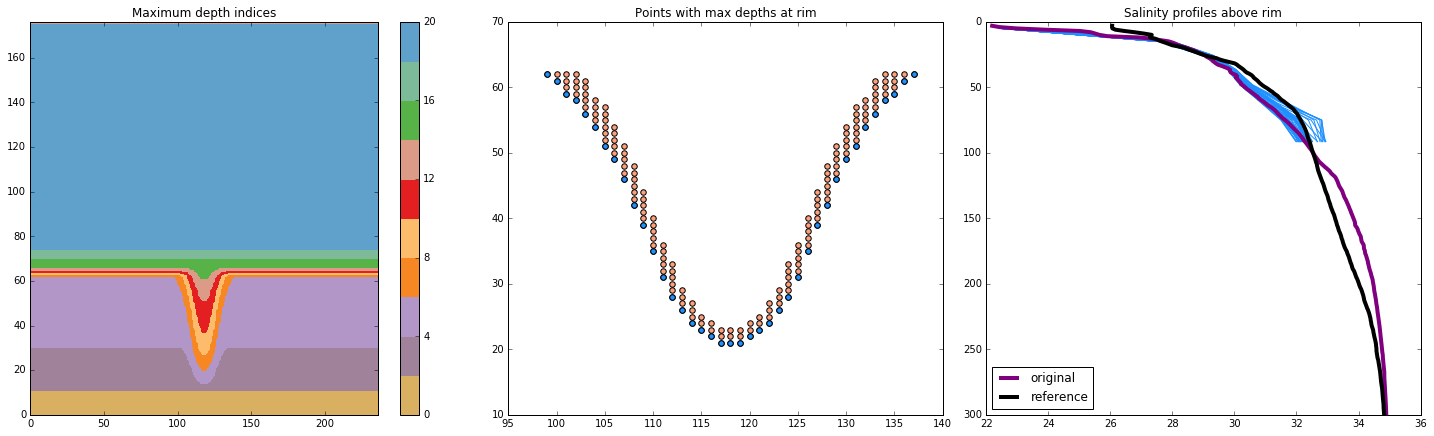

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20,6))
fig.tight_layout(); fig.subplots_adjust(hspace=.3, wspace=.1)
#matplotlib.rcParams.update({'font.size': 14})
p1 = ax1.contourf(inds_max_depth, cmap = 'Paired_r', levels=np.arange(22)[::2])
fig.colorbar(p1, ax=ax1); ax1.set_title('Maximum depth indices')

ax2.scatter(x_ind_rim_depth, y_ind_rim_depth, s = 30, c = 'lightsalmon')
ax2.scatter(unique_x_values, ys_for_unique_x_values, s = 30, c='dodgerblue')
ax2.set_title('Points with max depths at rim')

ax3.plot(sal_profiles_rim, grid['deptht'], c='dodgerblue', label='')
ax3.plot(sal_can, dep_can, lw = 2, c='purple', linewidth=4, label = 'original')
ax3.plot(sal_ref, dep_ref, lw = 2, c='k', linewidth=4, label = 'reference')
ax3.set_ylim([300,0]); ax3.legend(loc=3)
ax3.set_title('Salinity profiles above rim')

<function matplotlib.pyplot.show>

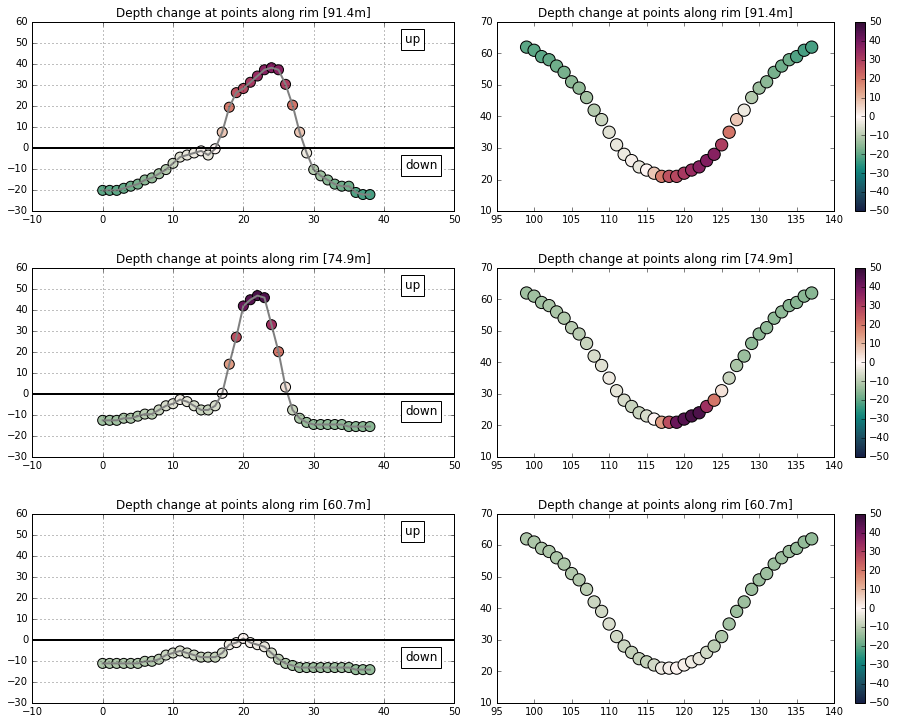

In [20]:
fig, ([ax4, ax5], [ax6, ax7], [ax8, ax9]) = plt.subplots(3, 2, figsize = (13,10))
fig.tight_layout(); fig.subplots_adjust(hspace=.3, wspace=.1)

depth_change, d_new = calculate_depth_change(depth_ind_rim)
ax4, ax5 = plot_rim_part(fig, ax4, ax5, depth_change, d_new)

depth_change, d_new = calculate_depth_change(depth_ind_rim-1)
ax6, ax7 = plot_rim_part(fig, ax6, ax7, depth_change, d_new)

depth_change, d_new = calculate_depth_change(depth_ind_rim-2)
ax8, ax9 = plot_rim_part(fig, ax8, ax9, depth_change, d_new)

plt.show